In [78]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

In [79]:
file_path=os.path.join(os.path.dirname(os.getcwd()),'data','preprocessed_data','processed_df.csv')
try:
    if os.path.exists(file_path) is not True :
        raise FileNotFoundError(f'The required file path is not found : {file_path}')
    df=pd.read_csv(file_path)
    print('Dataset Loaded Succesfully ...')
    print(f'Dataset have : {df.shape[0] } rows and {df.shape[1]} columns.')
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f'Unexpected error is occcured :{str(e)}')

Dataset Loaded Succesfully ...
Dataset have : 28054 rows and 11 columns.


In [80]:
# Group by date and part to count daily demand :
daily_demand_df = df.groupby(['invoice_date', 'Spare_parts']).size().reset_index(name='demand_count')

In [81]:
daily_demand_df.groupby('Spare_parts')['invoice_date'].nunique().reset_index()

,Spare_parts,invoice_date
0,10 size nut,2
1,12 size bolt,2
2,3m oil,517
3,4 way switch,2
4,6004 bearing,2
...,...,...
485,Wiring labour,4
486,Yoke,21
487,Yoke lever,2
488,Yoke rubber,4


In [82]:
daily_demand_df.groupby('Spare_parts')['demand_count'].sum().reset_index()

,Spare_parts,demand_count
0,10 size nut,2
1,12 size bolt,2
2,3m oil,1615
3,4 way switch,2
4,6004 bearing,2
...,...,...
485,Wiring labour,4
486,Yoke,21
487,Yoke lever,2
488,Yoke rubber,4


In [83]:
# Building an Summary Table for Filtering how many days each spare part has demand:
part_summary = daily_demand_df.groupby('Spare_parts')['invoice_date'].nunique().reset_index()
part_summary.columns = ['Spare_parts', 'active_days']

# Total demand for each part :
total_demand = daily_demand_df.groupby('Spare_parts')['demand_count'].sum().reset_index()
part_summary = part_summary.merge(total_demand, on='Spare_parts')

part_summary.sort_values('active_days', ascending=False).reset_index(drop=True).head()


,Spare_parts,active_days,demand_count
0,Engine oil,553,3798
1,Chain lubrication,548,3412
2,General service,535,2126
3,3m oil,517,1615
4,Consumables,511,1582


In [84]:
df['year'].unique()

array([2017, 2018, 2019], dtype=int64)

In [85]:
## Classifying Spare Parts into Forecasting Groups :
def categorize(row):
    if row['active_days'] > 300:
        return 'daily'
    elif row['active_days'] > 100:
        return 'weekly'
    elif row['active_days'] > 50:
        return 'low_priority'
    else:
        return 'ignore'

part_summary['forecast_strategy'] = part_summary.apply(categorize, axis=1)

part_summary


,Spare_parts,active_days,demand_count,forecast_strategy
0,10 size nut,2,2,ignore
1,12 size bolt,2,2,ignore
2,3m oil,517,1615,daily
3,4 way switch,2,2,ignore
4,6004 bearing,2,2,ignore
...,...,...,...,...
485,Wiring labour,4,4,ignore
486,Yoke,21,21,ignore
487,Yoke lever,2,2,ignore
488,Yoke rubber,4,4,ignore


In [86]:

part_summary[part_summary['forecast_strategy']=='ignore'].sort_values(by='active_days',ascending=False).reset_index(drop=True)

,Spare_parts,active_days,demand_count,forecast_strategy
0,Washing,50,52,ignore
1,Master cylender,49,53,ignore
2,Accelator cable,48,51,ignore
3,Loading gear,47,52,ignore
4,Crank shaft,46,50,ignore
...,...,...,...,...
431,Radiator fan,1,1,ignore
432,Radiator overhual,1,1,ignore
433,Fuel wiring kit,1,1,ignore
434,Fuel tap,1,1,ignore


In [87]:
part_summary['forecast_strategy'].value_counts().to_string

<bound method Series.to_string of forecast_strategy
ignore          436
low_priority     30
daily            12
weekly           12
Name: count, dtype: int64>

In [88]:
# Split parts by strategy :
daily_parts = part_summary[part_summary['forecast_strategy'] == 'daily']
weekly_parts = part_summary[part_summary['forecast_strategy'] == 'weekly']
low_priority_parts = part_summary[part_summary['forecast_strategy'] == 'low_priority']
ignore_parts = part_summary[part_summary['forecast_strategy'] == 'ignore']


In [89]:
daily_parts.sort_values(by='active_days',ascending=False).reset_index(drop=True)

,Spare_parts,active_days,demand_count,forecast_strategy
0,Engine oil,553,3798,daily
1,Chain lubrication,548,3412,daily
2,General service,535,2126,daily
3,3m oil,517,1615,daily
4,Consumables,511,1582,daily
5,Polish,474,1236,daily
6,Air filter,467,1695,daily
7,Brake shoe,431,858,daily
8,Oil filter,408,813,daily
9,Disc oil,391,984,daily


In [90]:
weekly_parts.sort_values(by='active_days',ascending=False).reset_index(drop=True)

,Spare_parts,active_days,demand_count,forecast_strategy
0,Chain sprocket,260,394,weekly
1,Clutch cable,244,340,weekly
2,Spark plug,242,414,weekly
3,Air filter checkup,230,465,weekly
4,Chain overhaul,196,283,weekly
5,Clutch assembly,161,209,weekly
6,Clutch cover gasket,146,187,weekly
7,Clutch overhual,124,162,weekly
8,Tank cover,118,132,weekly
9,Sprocket bearing,112,311,weekly


In [91]:
daily_demand_df['invoice_date']=pd.to_datetime(daily_demand_df['invoice_date'], dayfirst=True, errors='coerce')

In [92]:
# Start with a common part like "Engine oil" :
part = "Engine oil"
time_df = daily_demand_df[daily_demand_df['Spare_parts'] == part][['invoice_date','demand_count']]
time_df = time_df.sort_values('invoice_date').reset_index(drop=True)
time_df = time_df.set_index('invoice_date')
daily_ts = time_df.resample('D').asfreq()
daily_ts['demand_count']=daily_ts['demand_count'].interpolate(method='linear')

In [93]:
time_df

,demand_count
invoice_date,
2017-05-30,1
2017-05-31,4
2017-06-01,7
2017-06-02,5
2017-06-03,5
...,...
2019-01-02,6
2019-01-03,6
2019-01-04,11


In [94]:
daily_ts['demand_count']=daily_ts['demand_count'].astype(int)

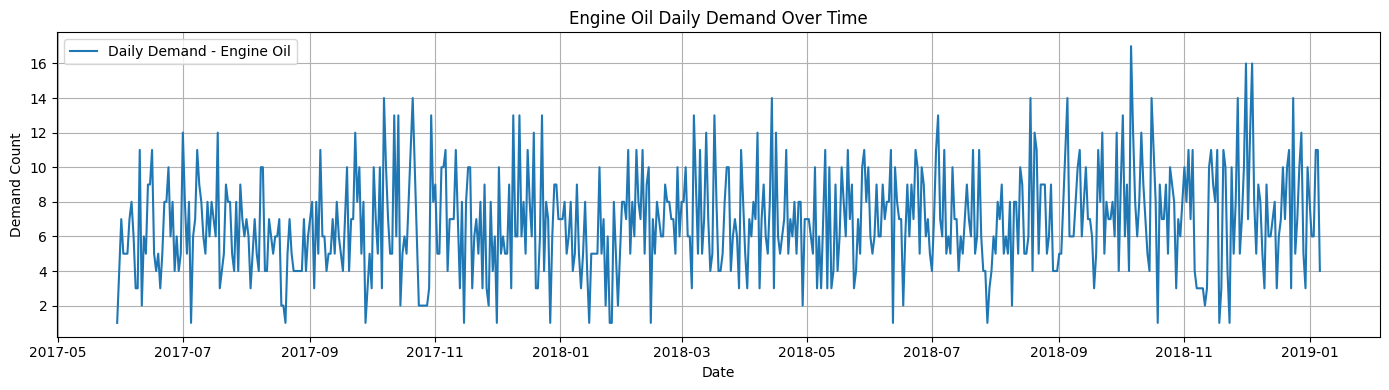

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(daily_ts, label='Daily Demand - Engine Oil')
plt.title('Engine Oil Daily Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

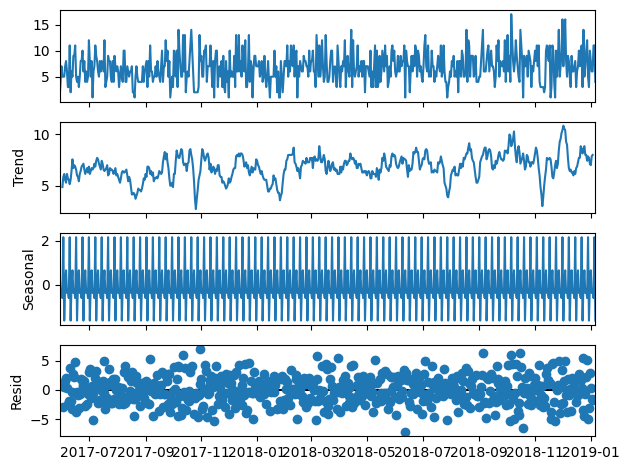

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(daily_ts, model='aditive')
decomposed.plot()
plt.show()

In [97]:
#Check Stationarity using ADF Test:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print(" Series is stationary")
    else:
        print(" Series is non-stationary — differencing may be needed")

adf_test(daily_ts['demand_count'])

ADF Statistic: -5.087783283363397
p-value: 1.483401787874924e-05
 Series is stationary


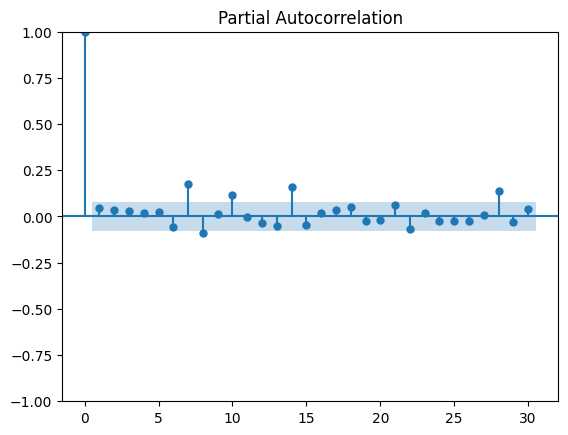

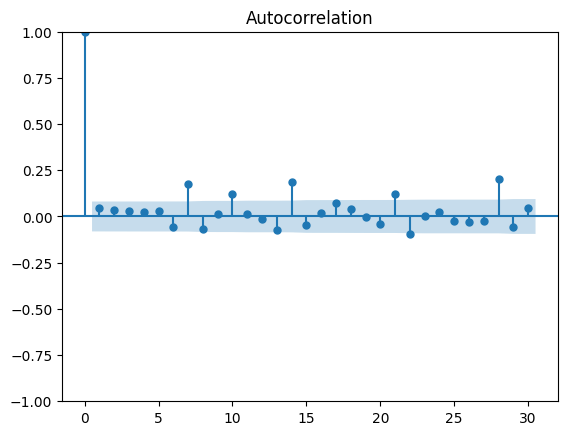

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(daily_ts['demand_count'].dropna(),lags=30)  
plot_acf(daily_ts['demand_count'].dropna(), lags=30)  
plt.show()

In [99]:
train = daily_ts[:-30]
test = daily_ts[-30:]

In [100]:
train

,demand_count
invoice_date,
2017-05-30,1
2017-05-31,4
2017-06-01,7
2017-06-02,5
2017-06-03,5
...,...
2018-12-03,12
2018-12-04,16
2018-12-05,8


In [101]:
adf_test(train)

ADF Statistic: -4.410545607731461
p-value: 0.00028433328839145514
 Series is stationary


In [102]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train['demand_count'],
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            d=None, 
                            seasonal=False, 
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3123.787, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2970.794, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3121.794, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2915.188, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2887.713, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2863.119, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2858.781, Time=0.52 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2856.832, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2861.160, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2779.275, Time=0.87 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2777.525, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2775.6

In [103]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['demand_count'], order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:           demand_count   No. Observations:                  557
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1383.341
Date:                Fri, 20 Jun 2025   AIC                           2770.682
Time:                        22:38:12   BIC                           2779.324
Sample:                    05-30-2017   HQIC                          2774.058
                         - 12-07-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9858      0.009   -112.295      0.000      -1.003      -0.969
sigma2         8.4295      0.509     16.572      0.000       7.433       9.426
Ljung-Box (L1) (Q):                   0.56   Jarque-

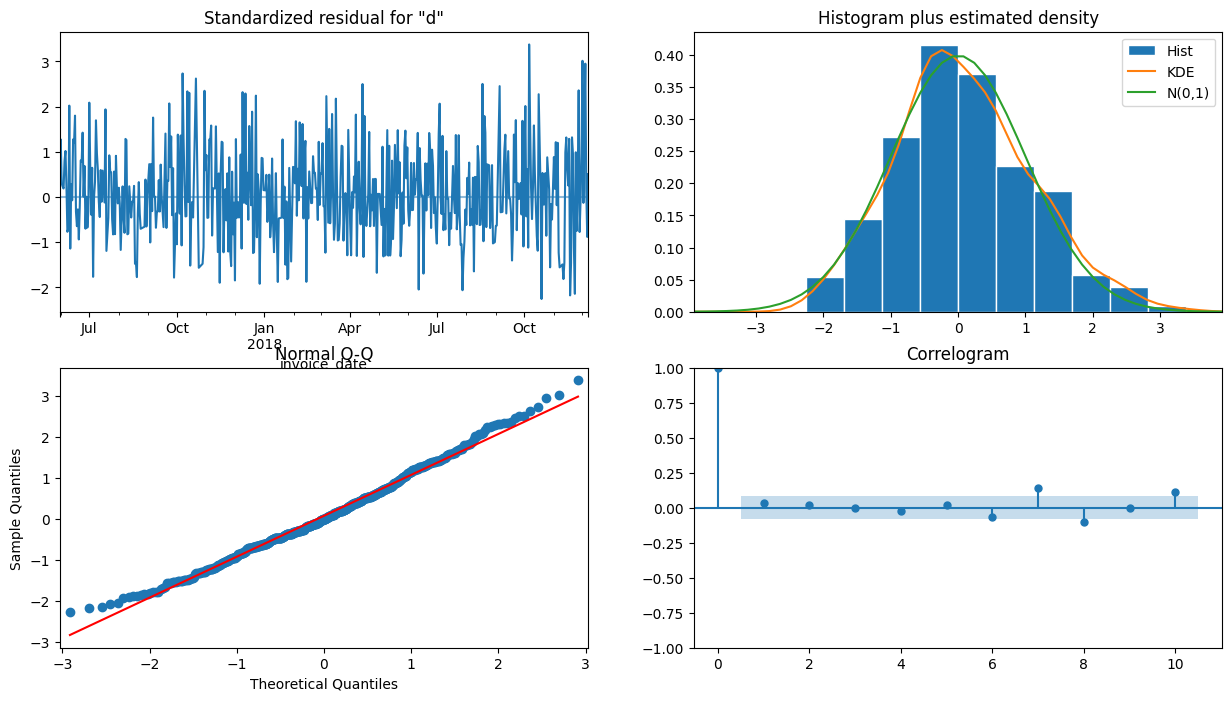

In [104]:
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

In [105]:
forecast = model_fit.forecast(steps=30)
forecast.index = test.index

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['demand_count'], forecast)
rmse = np.sqrt(mean_squared_error(test['demand_count'], forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.44
RMSE: 2.90


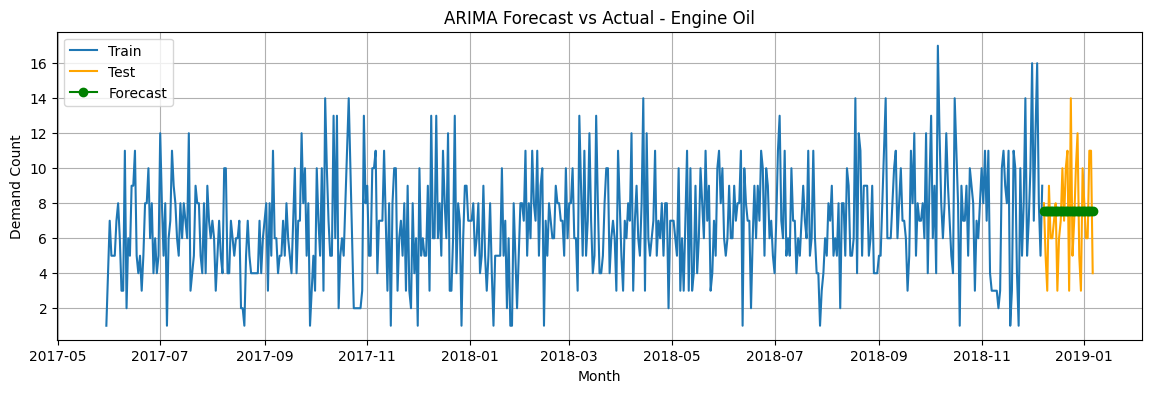

In [107]:
plt.figure(figsize=(14,4))
plt.plot(train.index, train['demand_count'], label='Train')
plt.plot(test.index, test['demand_count'], label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green', marker='o')
plt.title("ARIMA Forecast vs Actual - Engine Oil")
plt.xlabel("Month")
plt.ylabel("Demand Count")
plt.legend()
plt.grid(True)
plt.show()

In [108]:
#SARIMX Model:
stepwise_model = auto_arima(train['demand_count'],
                            start_p=0, start_q=0,
                            max_p=3, max_q=3,
                            start_P=0, start_Q=0,
                            max_P=2, max_Q=2,
                            d=None, D=None,
                            seasonal=True,
                            m=7,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3123.787, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2956.127, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3121.794, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2970.794, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2936.230, Time=0.88 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.45 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=3067.774, Time=0.40 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=2889.901, Time=1.07 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=2906.023, Time=0.92 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=7.87 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=2865.752, Time=2.45 sec
 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=2876.916, Time=1

In [109]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print(order)
print(seasonal_order)

(3, 1, 0)
(2, 0, 0, 7)


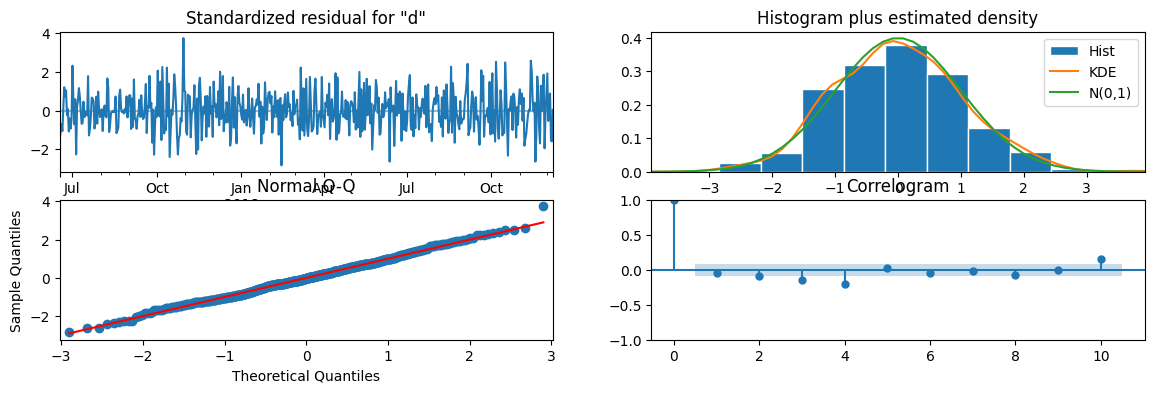

In [110]:
#Fitting SARIMAX model :
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['demand_count'], 
                order=order, 
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
results.plot_diagnostics(figsize=(14,4))
plt.show()


In [111]:
forecast = results.predict(start=len(train), end=len(train)+29)

In [112]:
# Evaluation forecast with test data :
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['demand_count'], forecast)
rmse = np.sqrt(mean_squared_error(test['demand_count'], forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.97
RMSE: 3.37


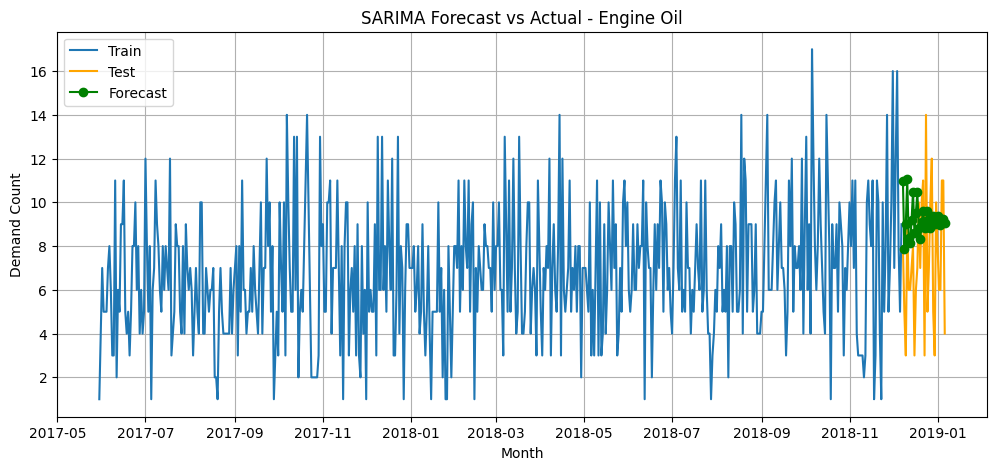

In [113]:
# Plot :
plt.figure(figsize=(12,5))
plt.plot(train.index, train['demand_count'], label='Train')
plt.plot(test.index, test['demand_count'], label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green', marker='o')
plt.title("SARIMA Forecast vs Actual - Engine Oil")
plt.xlabel("Month")
plt.ylabel("Demand Count")
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# Prophet Model:
from prophet import Prophet
train_prophet = train.reset_index().rename(columns={'invoice_date': 'ds', 'demand_count': 'y'})
test_prophet = test.reset_index().rename(columns={'invoice_date': 'ds', 'demand_count': 'y'})

model = Prophet(daily_seasonality=True)
model.fit(train_prophet)
future = model.make_future_dataframe(periods=len(test), freq='D')

forecast = model.predict(future)
forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').loc[test.index]
test_actuals = test['demand_count']

22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
# Evaluation Forecast with test data :
mae = mean_absolute_error(test_actuals, forecast_filtered['yhat'])
rmse = np.sqrt(mean_squared_error(test_actuals, forecast_filtered['yhat']))
print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")

Prophet MAE: 2.26
Prophet RMSE: 2.74


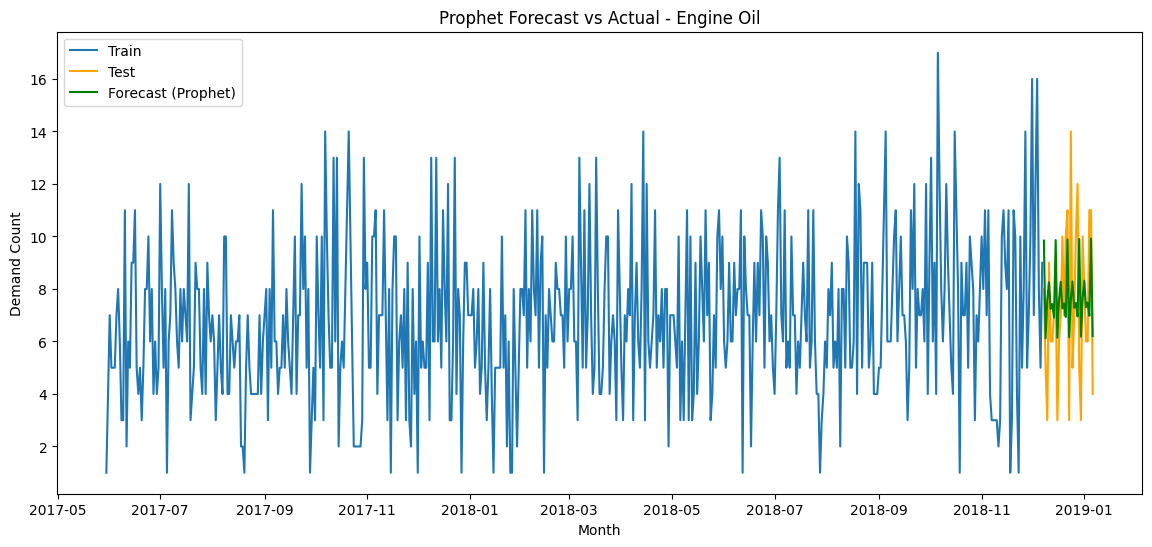

In [116]:
# Plot forecast Demand :
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['demand_count'], label='Train')
plt.plot(test.index, test['demand_count'], label='Test', color='orange')
plt.plot(forecast_filtered.index, forecast_filtered['yhat'], label='Forecast (Prophet)', color='green')
plt.legend()
plt.title("Prophet Forecast vs Actual - Engine Oil")
plt.xlabel("Month")
plt.ylabel("Demand Count")
plt.show()

In [117]:
import pandas as pd

def preprocess_time_series(daily_demand_df,part_name,freq='D',method='linear',fill_limit=None):
    # Filter and sort data for the selected part : 
    part_df = daily_demand_df[daily_demand_df['Spare_parts'] == part_name][['invoice_date', 'demand_count']]
    part_df = part_df.sort_values('invoice_date').reset_index(drop=True)
    part_df = part_df.set_index('invoice_date')
    if freq == 'D':
        part_ts = part_df.resample('D').asfreq()
    elif freq == 'W':
        part_ts = part_df.resample('W').sum().asfreq('W')
    else:
        raise ValueError("Unsupported frequency. Use 'D' for daily or 'W' for weekly.")

    part_ts['demand_count'] = part_ts['demand_count'].interpolate(method=method, limit=fill_limit)

    return part_ts

In [118]:
daily_parts

,Spare_parts,active_days,demand_count,forecast_strategy
2,3m oil,517,1615,daily
10,Air filter,467,1695,daily
45,Brake shoe,431,858,daily
74,Chain lubrication,548,3412,daily
106,Consumables,511,1582,daily
121,Disc oil,391,984,daily
124,Disc pad,323,529,daily
144,Engine oil,553,3798,daily
204,General service,535,2126,daily
311,Oil filter,408,813,daily


In [119]:
weekly_parts

,Spare_parts,active_days,demand_count,forecast_strategy
11,Air filter checkup,230,465,weekly
75,Chain overhaul,196,283,weekly
78,Chain sprocket,260,394,weekly
82,Clutch assembly,161,209,weekly
84,Clutch cable,244,340,weekly
88,Clutch cover gasket,146,187,weekly
92,Clutch overhual,124,162,weekly
261,Labour,103,130,weekly
400,Spark plug,242,414,weekly
414,Sprocket bearing,112,311,weekly


In [120]:
daily_demand_df

,invoice_date,Spare_parts,demand_count
0,2017-05-30,Engine oil,1
1,2017-05-31,3m oil,2
2,2017-05-31,Chain lubrication,2
3,2017-05-31,Engine oil,4
4,2017-05-31,General service,1
...,...,...,...
12636,2019-01-06,Number plate,1
12637,2019-01-06,Number plate clamp,1
12638,2019-01-06,Oil filter,1
12639,2019-01-06,Polish,2


In [121]:
# Prophet model for daily spare parts:

from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os

# Create output directory for plots :
os.makedirs("Forecast_plots/prophet_daily_forecast_plots", exist_ok=True)

all_forecasts = []

for part in daily_parts['Spare_parts'].unique():
    print(f"\nProcessing: {part}")
    part_df = preprocess_time_series(daily_demand_df=daily_demand_df, part_name=part, freq='D', method='time')
    train = part_df[:-30]
    test = part_df[-30:]
    train_prophet = train.reset_index().rename(columns={'invoice_date': 'ds', 'demand_count': 'y'})
    test_prophet = test.reset_index().rename(columns={'invoice_date': 'ds', 'demand_count': 'y'})
    train_prophet['y'] = np.log1p(train_prophet['y'])

    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=False,
        yearly_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.1
    )
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=7)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=12)
    model.fit(train_prophet)
    
    future = model.make_future_dataframe(periods=60, freq='D')
    forecast = model.predict(future)
    forecast = forecast.set_index('ds')
    # Inverse log transformation :
    forecast['yhat'] = np.expm1(forecast['yhat'].clip(lower=0))
    forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'].clip(lower=0))
    forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'].clip(lower=0))

    # Evaluate :
    test_dates = test.index
    forecast_eval = forecast.loc[test_dates]

    mae = mean_absolute_error(test['demand_count'], forecast_eval['yhat'])
    rmse = np.sqrt(mean_squared_error(test['demand_count'], forecast_eval['yhat']))
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")

    # Plot forecast vs actual :
    plt.figure(figsize=(14, 6))
    plt.plot(train.index, train['demand_count'], label='Train')
    plt.plot(test.index, test['demand_count'], label='Test', color='orange')
    plt.plot(forecast.index, forecast['yhat'], label='Forecast (30d)', color='green')
    plt.fill_between(
        forecast.index, forecast['yhat_lower'], forecast['yhat_upper'],
        color='green', alpha=0.2, label='Confidence Interval'
    )
    plt.title(f"Prophet Daily Forecast (log) - {part}")
    plt.xlabel("Date")
    plt.ylabel("Daily Demand Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Forecast_plots/prophet_daily_forecast_plots/{part}_forecast.png")
    plt.close()

    # Saving forecast's for next 30 days :
    forecast_next_30d = forecast[['yhat']].tail(30).copy().reset_index()
    forecast_next_30d['Spare_parts'] = part
    all_forecasts.append(forecast_next_30d.rename(columns={'ds': 'date', 'yhat': 'forecast_demand'}))

# Save final daily forecast :
final_forecast_df = pd.concat(all_forecasts).reset_index(drop=True)
final_forecast_df.to_csv("F:\Machine_Learning\Ml_Projects\Inventory Management\data\Forecast\prophet_30_day_demand_forecast.csv", index=False)

print("\nDaily forecasting complete with LOG transform.")
print("\nForecast plots saved in 'prophet_daily_forecast_plots/'")
print("\nForecast CSV saved as 'prophet_30_day_demand_forecast.csv'")



Processing: 3m oil


22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.56 | RMSE: 1.94

Processing: Air filter


22:39:33 - cmdstanpy - INFO - Chain [1] start processing
22:39:33 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.99 | RMSE: 2.35

Processing: Brake shoe


22:39:35 - cmdstanpy - INFO - Chain [1] start processing
22:39:36 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.10 | RMSE: 1.26

Processing: Chain lubrication


22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.06 | RMSE: 2.61

Processing: Consumables


22:39:41 - cmdstanpy - INFO - Chain [1] start processing
22:39:41 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.46 | RMSE: 1.90

Processing: Disc oil


22:39:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.56 | RMSE: 1.90

Processing: Disc pad


22:39:47 - cmdstanpy - INFO - Chain [1] start processing
22:39:48 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.57 | RMSE: 0.70

Processing: Engine oil


22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.31 | RMSE: 2.76

Processing: General service


22:39:53 - cmdstanpy - INFO - Chain [1] start processing
22:39:53 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.64 | RMSE: 2.11

Processing: Oil filter


22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.02 | RMSE: 1.20

Processing: Polish


22:39:58 - cmdstanpy - INFO - Chain [1] start processing
22:39:59 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.43 | RMSE: 1.81

Processing: Wheel rubber


22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.82 | RMSE: 0.90

Daily forecasting complete with LOG transform.

Forecast plots saved in 'prophet_daily_forecast_plots/'

Forecast CSV saved as 'prophet_30_day_demand_forecast.csv'


In [122]:
weekly_parts

,Spare_parts,active_days,demand_count,forecast_strategy
11,Air filter checkup,230,465,weekly
75,Chain overhaul,196,283,weekly
78,Chain sprocket,260,394,weekly
82,Clutch assembly,161,209,weekly
84,Clutch cable,244,340,weekly
88,Clutch cover gasket,146,187,weekly
92,Clutch overhual,124,162,weekly
261,Labour,103,130,weekly
400,Spark plug,242,414,weekly
414,Sprocket bearing,112,311,weekly


In [123]:
# Prophet model for weekly spare parts :

from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

os.makedirs("Forecast_plots/prophet_weekly_forecast_plots", exist_ok=True)
all_forecasts = []

USE_LOG = True

for part in weekly_parts['Spare_parts'].unique():
    print(f"\nProcessing: {part}")

    try:
        part_df = preprocess_time_series(daily_demand_df=daily_demand_df, part_name=part, freq='W', method='time')
        train = part_df[:-12]
        test = part_df[-12:]
        train_prophet = train.reset_index().rename(columns={'invoice_date': 'ds', 'demand_count': 'y'})
        test_prophet = test.reset_index().rename(columns={'invoice_date': 'ds', 'demand_count': 'y'})

        if USE_LOG:
            train_prophet['y'] = np.log1p(train_prophet['y'])

        model = Prophet(
            weekly_seasonality=True,
            daily_seasonality=False,
            yearly_seasonality=False,
            seasonality_mode='additive',
            changepoint_prior_scale=0.05
        )
        model.add_seasonality(name='monthly', period=4.35, fourier_order=4)
        model.add_seasonality(name='yearly', period=52.18, fourier_order=6)

        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=24, freq='W')
        forecast = model.predict(future)
        forecast.set_index('ds', inplace=True)

        if USE_LOG:
            forecast['yhat'] = np.expm1(forecast['yhat'])
            forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
            forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

        # Evaluate :
        forecast_eval = forecast.loc[test.index]
        y_true = test['demand_count']
        y_pred = forecast_eval['yhat'].clip(lower=0)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")

        # Plot :
        plt.figure(figsize=(14, 4))
        plt.plot(train.index, train['demand_count'], label='Train')
        plt.plot(test.index, test['demand_count'], label='Test', color='orange')
        plt.plot(forecast.index, forecast['yhat'], label='Forecast', color='green')
        plt.fill_between(
            forecast.index,
            forecast['yhat_lower'],
            forecast['yhat_upper'],
            color='green', alpha=0.2, label='Confidence Interval'
        )
        plt.title(f"Prophet Weekly Forecast - {part}")
        plt.xlabel("Date")
        plt.ylabel("Weekly Demand")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"Forecast_plots/prophet_weekly_forecast_plots/{part}_forecast.png")
        plt.close()

        forecast_12w = forecast[['yhat']].tail(12).reset_index()
        forecast_12w['Spare_parts'] = part
        forecast_12w.rename(columns={'ds': 'date', 'yhat': 'forecast_demand'}, inplace=True)
        all_forecasts.append(forecast_12w)

    except Exception as e:
        print(f"Skipped {part} due to error: {e}")

# Final forecast export :
final_df = pd.concat(all_forecasts).reset_index(drop=True)
final_df.to_csv("F:\Machine_Learning\Ml_Projects\Inventory Management\data\Forecast\prophet_12_week_demand_forecast.csv", index=False)

print("\nWeekly forecasting complete.")
print("\nForecast plots saved in 'prophet_weekly_forecast_plots/'")
print("\nForecast CSV saved as 'prophet_12_week_demand_forecast.csv'")



Processing: Air filter checkup


22:40:04 - cmdstanpy - INFO - Chain [1] start processing
22:40:05 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.06 | RMSE: 2.41

Processing: Chain overhaul


22:40:06 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.63 | RMSE: 3.08

Processing: Chain sprocket


22:40:08 - cmdstanpy - INFO - Chain [1] start processing
22:40:09 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.13 | RMSE: 3.77

Processing: Clutch assembly


22:40:10 - cmdstanpy - INFO - Chain [1] start processing
22:40:10 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.89 | RMSE: 3.67

Processing: Clutch cable


22:40:12 - cmdstanpy - INFO - Chain [1] start processing
22:40:13 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.68 | RMSE: 4.35

Processing: Clutch cover gasket


22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:15 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.55 | RMSE: 3.41

Processing: Clutch overhual


22:40:17 - cmdstanpy - INFO - Chain [1] start processing
22:40:17 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.04 | RMSE: 2.38

Processing: Labour


22:40:19 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.41 | RMSE: 1.86

Processing: Spark plug


22:40:21 - cmdstanpy - INFO - Chain [1] start processing
22:40:22 - cmdstanpy - INFO - Chain [1] done processing


MAE: 6.38 | RMSE: 7.77

Processing: Sprocket bearing


22:40:23 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing


MAE: 15.08 | RMSE: 16.52

Processing: Sprocket rubber


22:40:25 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing


MAE: 14.87 | RMSE: 17.13

Processing: Tank cover


22:40:27 - cmdstanpy - INFO - Chain [1] start processing
22:40:28 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.94 | RMSE: 1.18

Weekly forecasting complete.

Forecast plots saved in 'prophet_weekly_forecast_plots/'

Forecast CSV saved as 'prophet_12_week_demand_forecast.csv'


In [124]:
# Inferencing daily and weeekly forecast demad count :
daily=pd.read_csv(r'F:\Machine_Learning\Ml_Projects\Inventory Management\data\Forecast\prophet_30_day_demand_forecast.csv')
weekly=pd.read_csv(r'F:\Machine_Learning\Ml_Projects\Inventory Management\data\Forecast\prophet_30_day_demand_forecast.csv')

In [125]:
daily['forecast_demand']=daily['forecast_demand'].round().astype(int)
daily.loc[daily['date']=='2019-02-05']

,date,forecast_demand,Spare_parts
29,2019-02-05,4,3m oil
59,2019-02-05,6,Air filter
119,2019-02-05,7,Chain lubrication
149,2019-02-05,4,Consumables
179,2019-02-05,5,Disc oil
239,2019-02-05,8,Engine oil
269,2019-02-05,5,General service
299,2019-02-05,2,Oil filter
329,2019-02-05,4,Polish


In [126]:
# Ensure 'date' is in datetime format :
daily['date'] = pd.to_datetime(daily['date'])
start_date = pd.to_datetime('2019-01-07')
end_date = pd.to_datetime('2019-02-05')
# Filter only forecasted dates within the next 30 days :
final_30_day_forecast = daily[
    (daily['date'] >= start_date) & 
    (daily['date'] <= end_date)
].copy()
final_30_day_forecast.sort_values(by=['date', 'Spare_parts'], inplace=True)
final_30_day_forecast.reset_index(drop=True, inplace=True)

In [127]:
## Saving the 30 days Forecasted data  :
try:
    file_path=os.path.join(os.path.dirname(os.getcwd()),'data','Forecast')
    os.makedirs(file_path,exist_ok=True)
    final_30_day_forecast.to_csv(os.path.join(file_path,'processed_df.csv'),index=False)
    print('processed_df.csv file is saved succesfully...')
except Exception as e:
    raise f'Exception occured : {str(e)}'

processed_df.csv file is saved succesfully...


In [128]:
final_30_day_forecast.sort_values(by='date',ascending=True).reset_index(drop=True)

,date,forecast_demand,Spare_parts
0,2019-01-07,3,3m oil
1,2019-01-07,2,Wheel rubber
2,2019-01-07,4,Polish
3,2019-01-07,2,Oil filter
4,2019-01-07,7,Engine oil
...,...,...,...
335,2019-02-05,4,Consumables
336,2019-02-05,5,Disc oil
337,2019-02-05,8,Engine oil
338,2019-02-05,5,General service


In [129]:
final_30_day_forecast.loc[final_30_day_forecast['date']=='2019-01-07']

,date,forecast_demand,Spare_parts
0,2019-01-07,3,3m oil
1,2019-01-07,3,Air filter
2,2019-01-07,2,Brake shoe
3,2019-01-07,6,Chain lubrication
4,2019-01-07,3,Consumables
5,2019-01-07,4,Disc oil
6,2019-01-07,1,Disc pad
7,2019-01-07,7,Engine oil
8,2019-01-07,4,General service
9,2019-01-07,2,Oil filter


In [130]:
final_30_day_forecast['Spare_parts'].unique()

array(['3m oil', 'Air filter', 'Brake shoe', 'Chain lubrication',
       'Consumables', 'Disc oil', 'Disc pad', 'Engine oil',
       'General service', 'Oil filter', 'Polish', 'Wheel rubber'],
      dtype=object)

In [131]:
weekly['forecast_demand']=weekly['forecast_demand'].round().astype(int)
weekly

,date,forecast_demand,Spare_parts
0,2019-01-07,3,3m oil
1,2019-01-08,4,3m oil
2,2019-01-09,4,3m oil
3,2019-01-10,4,3m oil
4,2019-01-11,3,3m oil
...,...,...,...
355,2019-01-14,2,Wheel rubber
356,2019-01-15,2,Wheel rubber
357,2019-01-16,2,Wheel rubber
358,2019-01-17,2,Wheel rubber


# Spare Parts Demand Forecasting Project :

## Objective :
To forecast the demand of spare parts using historical invoice data to help maintain optimal inventory levels at service centers.


## 1. Dataset Overview :
- The dataset consists of spare parts transaction data with the following key columns:
  - `invoice_date`
  - `Spare_parts`
  - `demand_count`
- Data spans across multiple years with both high and low frequency parts.


## 2. Data Preprocessing :
- Parsed `invoice_date` into datetime format.
- Grouped and aggregated demand per day (`daily`) and per week (`weekly`) for each spare part.
- Handled missing values:
  - For daily: Used `.resample('D').asfreq()` followed by interpolation.
  - For weekly: Used `.resample('W').sum()` to account for total weekly demand.


## 3. Time Series Modeling :
We used **Facebook Prophet** due to its capabilities in handling:
- Irregular time series
- Automatic changepoint detection
- Built-in support for seasonality (daily, weekly, yearly)

### Daily Forecasting :
- Used Prophet with:
  - `daily_seasonality=True`
  - Added custom seasonalities:
    - Weekly: `period=7`, `fourier_order=3`
    - Monthly: `period=30.5`, `fourier_order=7`
    - Yearly: `period=365.25`, `fourier_order=12`
  - Log transformation applied to stabilize variance.
- Forecasted next 30 days of demand.
- Evaluated with MAE and RMSE metrics.

### Weekly Forecasting :
- Used Prophet with:
  - `weekly_seasonality=True`
  - Added seasonalities:
    - Monthly: `period=4.35`, `fourier_order=4`
    - Yearly: `period=52.18`, `fourier_order=6`
  - Log transformation applied.
- Forecasted next 12 weeks of demand.
- Evaluated with MAE and RMSE metrics.


## 4. Model Performance :
- Prophet performed well on many parts.
- For parts with sparse demand or highly noisy signals, performance was limited.
- Parts with consistently flat demand showed near-zero error due to constant values.


## 5. Final Output :
- Forecasted values were rounded to integers to match demand counts.
- Output saved as:
  - `prophet_30_day_demand_forecast.csv`
  - `prophet_12_week_demand_forecast.csv`
- Plots saved in:
  - `prophet_forecast_plots/`
  - `prophet_weekly_forecast_plots/`


## 6. Business Recommendations
- Use the forecasted values for stocking high and medium priority spare parts.
- For **low-priority** and **ignored** parts, maintain a **safety minimum level** based on historical average or expert input.
- Re-train models periodically as new data becomes available.





## Conclusion
- Prophet proved to be a suitable model for both daily and weekly forecasting needs.
- Seasonality and changepoint detection enhanced demand prediction accuracy.
- Proper data preprocessing and transformation significantly improved results.